# 14개의 feature 모두 넣고 ACC구하기

In [51]:
import warnings
warnings.filterwarnings(action='ignore')
import os, sys

import pandas as pd
import numpy as np
import warnings
import timeit
import datetime
from scipy import interp

import keras
from keras import callbacks
from keras import losses
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout


from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import auc, roc_curve, roc_auc_score  # plot_roc_curve


%matplotlib inline
import matplotlib.pyplot as plt

import sonyalib as sonya

In [52]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


def mlp_model(num_input, dropout=0, lr=0.005, l1=9, l2=9):
    keras.backend.clear_session()
    ## 모델 구성하기
    model = Sequential()
    # print learning rate
    optimizer = Adam(lr=0.001)
    lr_metric = get_lr_metric(optimizer)

    model.add(Dense(l1, activation='relu', input_dim=num_input, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dense(l2, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

    ## 모델 컴파일
    model.compile(optimizer=Adam(lr), loss=losses.binary_crossentropy, metrics=['accuracy'])

    # model.summary()
    return model


In [53]:
def cross_validation(model, X, y, nfold=5, nbatch=5, nlr=0.001, l1=16, l2=16):
    global record_count
    kfold = KFold(n_splits=nfold, shuffle=True)
    accuracy = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # K-fold cross validation
    # 학습 데이터를 이용해서 학습

    i = 1
    for train_index, validation_index in kfold.split(X, y):

        kX_train, kX_test = X.iloc[train_index], X.iloc[validation_index]
        ky_train, ky_test = y.iloc[train_index], y.iloc[validation_index]

        print("======================batch: {}, lr = {}, FOLD: {}====================".format(nbatch, nlr, i))
        cbks = [callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 2)),
                callbacks.TensorBoard(write_graph=False)]
        # hist = model.fit(kX_train, ky_train, epochs=500, batch_size=5, validation_data=(kX_test,ky_test),callbacks=[tb_hist])
        model.fit(kX_train, ky_train, epochs=500, batch_size=nbatch, validation_data=(kX_test, ky_test), callbacks=cbks, verbose=2)
        # model.save('brc_mlp_model.h5')

        y_val_cat_prob = model.predict_proba(kX_test)

        k_accuracy = '%.4f' % (model.evaluate(kX_test, ky_test)[1])
        accuracy.append(k_accuracy)

        # roc curve
        fpr, tpr, t = roc_curve(y.iloc[validation_index], y_val_cat_prob)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        # final_lr = model.optimizer.lr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f) ' % (i, roc_auc))
        i = i + 1

        
    # 전체 검증 결과 출력
    print('\nK-fold cross validation Accuracy: {}'.format(accuracy))
    # print('\nK-fold cross validation mean Accuracy: {}'.format(np.mean(accuracy)))
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    file_name = str("{}b{}_lr{}_1st{}_2nd{}".format(current_time, nbatch, nlr, l1, l2))
    #
    # ## 모델저장
    # model_json = model.to_json()
    # # if os.path.isfile(".model/{}.json".format(file_name)):
    # with open(".model/{}.json".format(file_name), "x") as json_file:
    #     print("saved model to disk")
    #     json_file.write(model_json)
    # # else:
    #
    #
    # ## weights 저장
    # model.save_weights(".model/{}.h5".format(file_name))
    # print("saved model weights to disk")
    #


    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
   
    font1 = {'family': 'serif',
             'color': 'darkred',
             'weight': 'normal',
             'size': 10}
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC(batch: {}, lr: {}, l1: {}, l2: {})'.format(nbatch, nlr, l1, l2))
    plt.legend(loc="lower right")
    
    plt.show()
    record_count = record_count + 1
    return mean_auc

In [75]:
start_time = timeit.default_timer()  # 시작 시간 체크
# ==== Step 1. Load original dataset
PATH_EXCEL = './BRC2019_CRF_merged_200717 복사본 (copy).xlsx'
metadata = sonya.get_metadata(PATH_EXCEL)

df_filtered = metadata.dropna(axis=0, how='any').reset_index(drop=True)  # NaN drop
properties = list(df_filtered.columns.values)
properties.remove('label')
### >>> FILTERING <<<<<<
properties.remove('cAverage')
properties.remove('cSD')
properties.remove('aAverage')
properties.remove('aSD')
properties.remove('non-mass')
properties.remove('rim')
properties.remove('hetero')
properties.remove('clustered')
properties.remove('age')
properties.remove('ID')
properties.remove('L/R')
properties.remove('LR')
X_origin = df_filtered[properties]
y_origin = df_filtered['label']
num_features = len(X_origin.columns)

print(X_origin)
print(properties)

X_origin_train, X_origin_test, y_origin_train, y_origin_test = train_test_split(X_origin, y_origin, test_size=0.3, random_state=0)

record_count = 0

# batch_size = [20]
# learning_rate = [0.05, 0.001]
# layer1 = [7, 9, 11]
# layer2 = [9, 11]
batch_size = 20
nlr = 0.001
l1 = 15
l2 = 15
my_model = mlp_model(num_features, lr=nlr, l1=l1, l2=l2)
roc_result = cross_validation(my_model, X_origin_train, y_origin_train,  nbatch=batch_size, nlr=nlr, l1=l1, l2=l2)

# new_record = {'Batch_size': nb, 'Learning_rate': nlr, '1st layer': l1, '2nd layer': l2,
#               "num_input": len(_X.columns), "input_params": _X.columns.values, "mean_ROC": roc_result}
# record.loc[i] = new_record


## ------------ TEST_Sensitivity --------------
# predIdxs = my_model.evaluate(X_origin_test,y_origin_test)
loss, accuracy = my_model.evaluate(X_origin_test,y_origin_test, steps=len(X_origin_test)//batch_size)
# predIdxs2 = my_model.predict(x=X_origin_test, steps=None)
print("============================================================")
print("test loss     : {:7.4f}".format(loss))
print("test accuracy : {:7.4f}".format(accuracy))
# print(predIdxs)
print("============================================================")
# print(predIdxs2)
# # predIdxs = my_model.predict(x=X_origin_test, steps=(len(_X) // BS) + 1)
# # predIdxs = my_model.predict(x=X_origin_test, steps=(totalTest // BS) + 1)

# # predIdxs = np.argmax(predIdxs, axis=1)
# # cm = confusion_matrix(y_origin_test, predIdxs)
# # cm2 = confusion_matrix(y_origin_test, predIdxs).ravel()
# # print(cm)
# # print(cm2)
# # # total = sum(sum(int(cm)))
# # # acc = (cm[0, 0] + cm[1, 1]) / total
# # sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
# # specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# #
# # print(cm)
# # print(cm2)
# # # print("acc: {:.4f}".format(acc))
# # print("sensitivity: {:.4f}".format(sensitivity))
# # print("specificity: {:.4f}".format(specificity))


# ## --------------------------------------------



         cT   hu_diff  homogeneous    cN
0    0.2000  0.611257         1.00  0.00
1    0.1375  0.237244         1.00  0.00
2    0.1875  0.448185         1.00  0.00
3    0.1125  0.542346         0.75  0.25
4    0.1875  0.401368         0.50  0.25
..      ...       ...          ...   ...
275  0.3125  0.469227         0.00  0.50
276  0.0875  0.419253         0.75  0.75
277  0.1375  0.290900         0.75  0.00
278  0.2250  0.375592         1.00  0.25
279  0.0750  0.290373         0.50  0.00

[280 rows x 4 columns]
['cT', 'hu_diff', 'homogeneous', 'cN']
======================batch: 20, lr = 0.001, FOLD: 1====================
Train on 156 samples, validate on 40 samples
Epoch 1/500
 - 0s - loss: 1.0165 - accuracy: 0.4295 - val_loss: 1.1053 - val_accuracy: 0.3750
Epoch 2/500
 - 0s - loss: 0.9422 - accuracy: 0.4744 - val_loss: 1.0341 - val_accuracy: 0.3750
Epoch 3/500
 - 0s - loss: 0.9294 - accuracy: 0.4872 - val_loss: 0.9887 - val_accuracy: 0.4000
Epoch 4/500
 - 0s - loss: 0.8728 - accuracy: 

TypeError: 'numpy.float64' object is not callable

In [42]:
loss, accuracy = my_model.evaluate(X_origin_test,y_origin_test)

print("test loss     : {}".format(loss))
print("test accuracy : {}".format(accuracy))

84/84 [==============================] - 0s 59us/step
test loss     : 0.39808998931021916
test accuracy : 0.7976190447807312


84/84 [==============================] - 0s 51us/step
test loss     : 0.6417768029939561
test accuracy : 0.6309523582458496


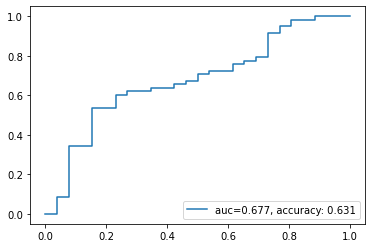

In [74]:
loss, accuracy = my_model.evaluate(X_origin_test,y_origin_test)
print("test loss     : {}".format(loss))
print("test accuracy : {}".format(accuracy))
y_pred_proba = my_model.predict_proba(X_origin_test)
fpr, tpr, _ = roc_curve(y_origin_test,  y_pred_proba)

auc = roc_auc_score(y_origin_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc={:.3f}, accuracy: {:.3f}".format(auc, accuracy))
plt.legend(loc=4)
plt.savefig("./t_test/"+str("4 input accuracy.png"), transparent=False) ## save to png
plt.show()